In [1]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import shutil
from pathlib import Path
import cv2
from PIL import Image
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [2]:
SEED = 42

def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)

def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

set_global_determinism(seed=SEED)

In [3]:
data_path = 'data/chest_xray'
train_path = Path(data_path + '/train')
test_path = Path(data_path + '/test')
val_path = Path(data_path + '/val')

LABELS = ['NORMAL', 'PNEUMONIA']
GRAYSCALE = False

# Data Exploration

## Image Visualisation

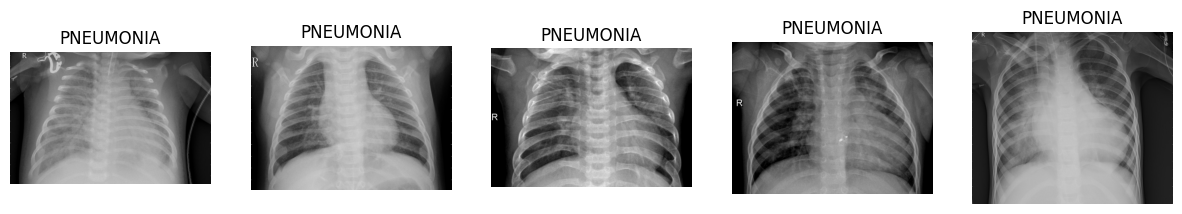

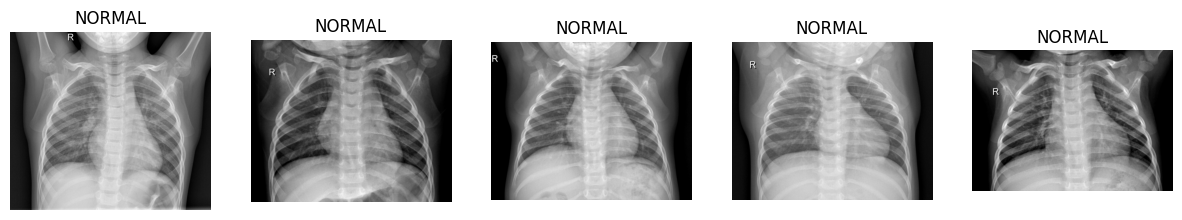

In [12]:
def display_sample_images(data_path, label, num_samples, grayscale):
    label_path = os.path.join(data_path, label)
    image_paths = list(Path(label_path).glob("*.jpeg"))[:num_samples]

    samples = []
    for img_path in image_paths:
        img = cv2.imread(str(img_path))
        if grayscale:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        samples.append(img)

    cmap = 'gray' if grayscale else None
    plt.figure(figsize=(15, 5))
    for i, img in enumerate(samples):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img, cmap=cmap)
        plt.title(label)
        plt.axis('off')
    plt.show()

display_sample_images(train_path, 'PNEUMONIA', 5, grayscale=GRAYSCALE)
display_sample_images(train_path, 'NORMAL', 5, grayscale=GRAYSCALE)

## Image Resolution Analysis

In [15]:
def analyze_image_res(directory_paths, labels):
    resolution_data = {label: [] for label in labels}
    
    for dir_path in directory_paths:
        for label in labels:
            label_dir = dir_path / label
            image_files = list(label_dir.glob("*.jpeg")) + list(label_dir.glob("*.jpg")) + list(label_dir.glob("*.png"))
            
            for img_path in image_files:
                try:
                    with Image.open(img_path) as img:
                        resolution_data[label].append(img.size)  # (width, height)
                except Exception as e:
                    print(f"Error reading {img_path}: {e}")
    
    return resolution_data

directories = [train_path, val_path, test_path]
res_data = analyze_image_res(directories, LABELS)

# Print out basic statistics on resolutions
for label in LABELS:
    widths = [res[0] for res in res_data[label]]
    heights = [res[1] for res in res_data[label]]
    if len(widths) > 0:
        print(f"{label} - {len(widths)}")
        print(f">>>>> Width  - min: {min(widths)}, max: {max(widths)}, mean: {np.mean(widths):.2f}")
        print(f">>>>> Height - min: {min(heights)}, max: {max(heights)}, mean: {np.mean(heights):.2f}")
        print()

NORMAL - 1583
>>>>> Width  - min: 912, max: 2916, mean: 1686.38
>>>>> Height - min: 496, max: 2713, mean: 1378.65

PNEUMONIA - 4273
>>>>> Width  - min: 384, max: 2772, mean: 1195.07
>>>>> Height - min: 127, max: 2304, mean: 819.55



- NORMAL images tend to have a higher mean width and height, whereas PNEUMONIA images are more diverse in resolution (some as low as 384×127 and as high as ~2772×2304).
- The fact that PNEUMONIA images are on average smaller (mean ~1195×820) but also range widely suggests they may come from multiple sources or devices. Meanwhile, NORMAL images appear more consistently sized at around 1686×1379 on average.
- Given the resolution disparity, it may be beneficial to standardize image sizes for model training to ensure consistent input dimensions.

## Histogram Analysis (Pixel Intensity Distribution)

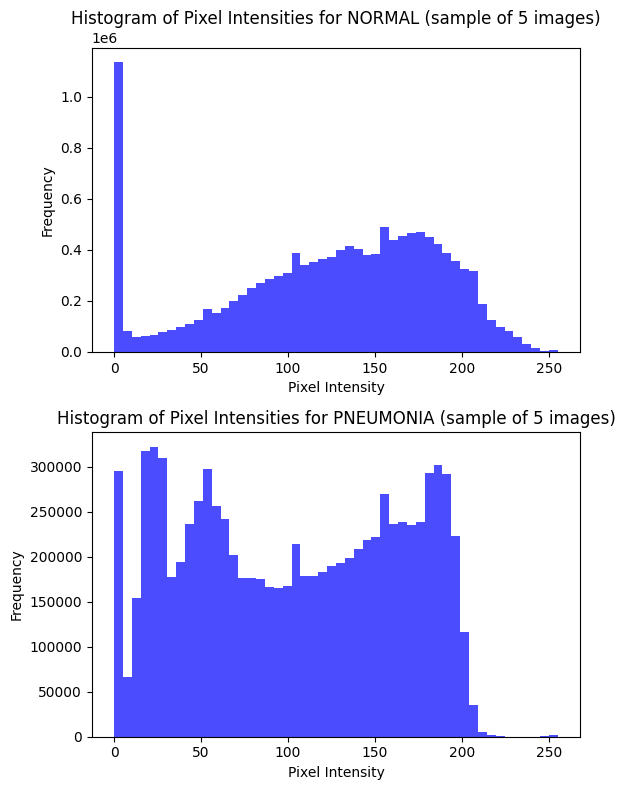

In [ ]:
def plot_histograms(directory_path, labels, num_images=5, bins=50):
    fig, axes = plt.subplots(len(labels), 1, figsize=(6, 4*len(labels)))
    
    if len(labels) == 1:
        axes = [axes]
    
    for i, label in enumerate(labels):
        label_dir = directory_path / label
        image_files = list(label_dir.glob("*.jpeg")) + list(label_dir.glob("*.jpg")) + list(label_dir.glob("*.png"))
        
        # random samples
        np.random.shuffle(image_files)
        selected_images = image_files[:num_images]
        
        all_pixels = []
        for img_path in selected_images:
            try:
                with Image.open(img_path).convert("L") as img:
                    img_array = np.array(img)
                    # flatten and store grayscale pixel values
                    all_pixels.extend(img_array.flatten())
            except Exception as e:
                print(f"Error reading {img_path}: {e}")
        
        axes[i].hist(all_pixels, bins=bins, color='blue', alpha=0.7)
        axes[i].set_title(f"Histogram of Pixel Intensities for {label} (sample of {len(selected_images)} images)")
        axes[i].set_xlabel("Pixel Intensity")
        axes[i].set_ylabel("Frequency")
    
    plt.tight_layout()
    plt.show()

plot_histograms(train_path, LABELS, num_images=5, bins=50)

**NORMAL:**
- A large spike near 0 (very dark pixels), then a somewhat smooth distribution peaking around midtones (100–200).
- The distribution is spread out, showing a notable frequency of brighter intensities as well.


**PNEUMONIA:**
- Also has a cluster of dark (low-intensity) pixels, though the spike near 0 is not quite as dominant.
- Multiple modes in the histogram, suggesting varying brightness/contrast within this class.


**Class Differences**
- Pneumonia images often contain visible opacities or consolidations that alter brightness patterns. The histogram with multiple peaks might reflect those variations.

**Potential Data Preprocessing**
- Because the brightness and contrast can vary significantly, applying some form of histogram equalization or min-max/standard normalization might help if the model does not do well by simply rescaling to [0, 1] by dividing by 255.

## Color Channels Statistics

In [17]:
def compute_statistics(directory_paths, labels):
    channel_sum = np.zeros(3, dtype=np.float64) # sums
    channel_sum_sq = np.zeros(3, dtype=np.float64) # sums of squares
    num_pixels_total = 0  # total number of pixels for all images
    
    for dir_path in directory_paths:
        for label in labels:
            label_dir = dir_path / label
            image_files = list(label_dir.glob("*.jpeg")) + list(label_dir.glob("*.jpg")) + list(label_dir.glob("*.png"))
            
            for img_path in image_files:
                try:
                    with Image.open(img_path) as img:
                        img = img.convert("RGB")
                        img_array = np.array(img, dtype=np.float64)  # (H, W, 3)

                        # spatial dimensions sum
                        channel_sum += img_array.sum(axis=(0, 1))
                        channel_sum_sq += (img_array ** 2).sum(axis=(0, 1))

                        # accumulate pixel count
                        num_pixels_total += img_array.shape[0] * img_array.shape[1]
                
                except Exception as e:
                    print(f"Error reading {img_path}: {e}")
    
    channel_mean = channel_sum / num_pixels_total
    channel_std = np.sqrt(channel_sum_sq / num_pixels_total - channel_mean ** 2)
    
    return channel_mean, channel_std

mean_rgb, std_rgb = compute_statistics([train_path], LABELS)
print("Training Set Mean (R, G, B):", mean_rgb)
print("Training Set Std  (R, G, B):", std_rgb)

# mean_rgb_val, std_rgb_val = compute_statistics([val_path], LABELS)
# mean_rgb_test, std_rgb_test = compute_statistics([test_path], LABELS)

Training Set Mean (R, G, B): [124.30439269 124.30439269 124.30439269]
Training Set Std  (R, G, B): [62.62273996 62.62273996 62.62273996]


The identical mean and standard deviation across the RGB channels suggest that many images were essentially grayscale or near-monochrome to begin with.

## Train, Test and Validation Sets Distribution

Total number of images in the dataset:  5856


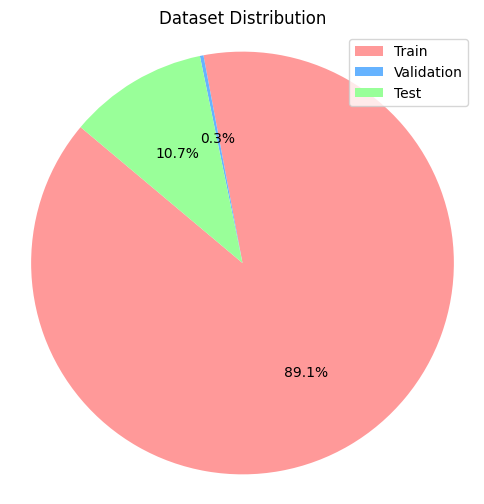

In [4]:
def plot_dataset_distribution(sizes, labels, title, colors=None):
    colors = colors or ['#ff9999', '#66b3ff', '#99ff99']
    plt.figure(figsize=(6, 6))
    wedges, texts, autotexts = plt.pie(sizes, autopct='%1.1f%%', startangle=140, colors=colors)
    plt.legend(wedges, labels)
    plt.title(title)
    plt.axis('equal')
    plt.show()

sizes = [
    sum(len(list((train_path / label).glob("*.jpeg"))) for label in LABELS),
    sum(len(list((val_path / label).glob("*.jpeg"))) for label in LABELS),
    sum(len(list((test_path / label).glob("*.jpeg"))) for label in LABELS)
]

print("Total number of images in the dataset: ", sum(sizes))
titles = ['Train', 'Validation', 'Test']
plot_dataset_distribution(sizes, titles, 'Dataset Distribution')

The result shows that the dataset is not balanced across the train, test and validation sets, with train set having 89.1% of the data, test set having 10.7% and validation set having 0.3%. This imbalance might hurt the model's performance. The extremely small validation set is particularly concerning as it may not provide a reliable estimate of the model's performance on unseen data.

We will mitigate this issue by resampling the dataset to ensure a more balanced distribution across the sets in the later stages of this notebook.

## Labels Distribution Analysis

       Class  Count
0     NORMAL   1341
1  PNEUMONIA   3875
Total:  5216


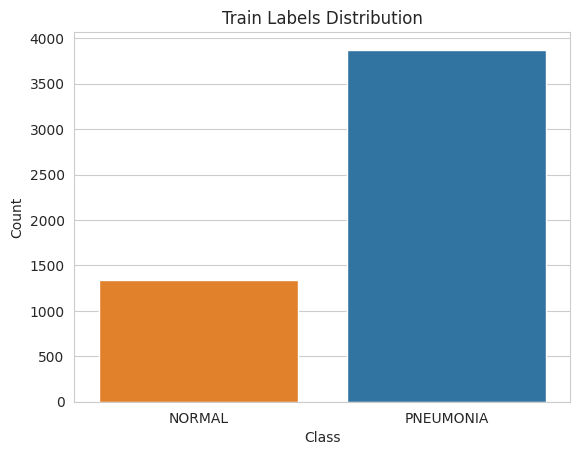

       Class  Count
0     NORMAL      8
1  PNEUMONIA      8
Total:  16


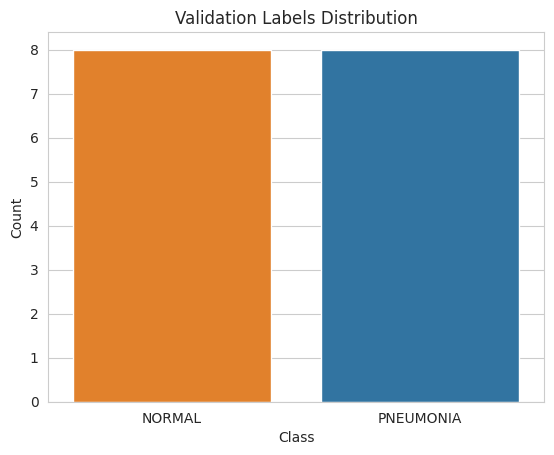

       Class  Count
0     NORMAL    234
1  PNEUMONIA    390
Total:  624


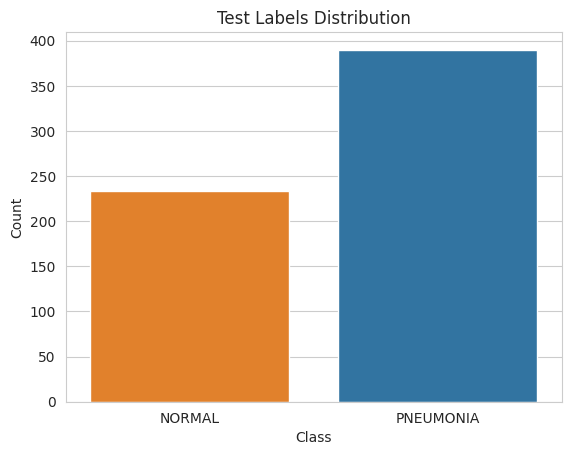

In [5]:
def plot_labels_distribution(data_path, labels, title):
    label_counts = {}

    for label in labels:
        label_dir = Path(data_path) / label
        count = len(list(label_dir.glob("*.jpeg")))
        label_counts[label] = count

    df = pd.DataFrame(list(label_counts.items()), columns=['Class', 'Count'])
    print(df)
    print("Total: ", sum(label_counts.values()))

    sns.set_style('whitegrid')
    sns.barplot(x='Class', y='Count', data=df, hue='Class', palette=['#ff7f0e', '#1f77b4'], legend=False)
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.show()

plot_labels_distribution(train_path, LABELS, 'Train Labels Distribution')
plot_labels_distribution(val_path, LABELS, 'Validation Labels Distribution')
plot_labels_distribution(test_path, LABELS, 'Test Labels Distribution')

The results show that the labels distrubution is not balanced, with the PNEUMONIA class being 2 - 3 times more frequent than NORMAL class. This can affect the performance of the classification models. We will explore methods such as data augmentation and oversampling during training to help mitigate this imbalance.

# Data Preparation

## Train, Validation and Test Datasets Resplit

The original distribution between the train, validation and test sets are too imbalance (0.89, 0.1, 0.01). This is a problem as the validation set is too small to be representative of the test set. Hence, we will combine the train, validation and test sets into one dataset and then split them into train, validation and test sets again. This will ensure that the validation set is large enough to be representative of the test set.

As the dataset and its paper does not provide any justifications on the train, validation and test distributions, and only describes that all data are validated by 3 tiers of human experts, we will assume that the distribution of the train, validation and test sets can be changed without affecting the model's performance on real-world data.

We will use the standard train-validation-test split of 0.75 : 0.15 : 0.15.

In [6]:
def copy_data(file_paths, destination):
    for file_path in file_paths:
        shutil.copy(file_path, destination)

def resplit_data(data_path, redistributed_data_path, split_ratios):
    all_data = []
    for label in LABELS:
        for split in ['train', 'val', 'test']:
            data_dir = Path(data_path) / split / label
            all_data.extend([(str(file), label) for file in data_dir.glob('*.jpeg')])

    df = pd.DataFrame(all_data, columns=['file_path', 'label'])
    train_data, temp = train_test_split(df, test_size=1-split_ratios['train'], random_state=SEED)
    val_data, test_data = train_test_split(temp, test_size=split_ratios['test'] / (split_ratios['test'] + split_ratios['val']), shuffle=False)

    for label in LABELS:
        copy_data(train_data[train_data['label'] == label]['file_path'].tolist(), redistributed_data_path / 'train' / label)
        copy_data(val_data[val_data['label'] == label]['file_path'].tolist(), redistributed_data_path / 'val' / label)
        copy_data(test_data[test_data['label'] == label]['file_path'].tolist(), redistributed_data_path / 'test' / label)


In [7]:
redistributed_data_path = Path('data/redistributed')
os.makedirs(redistributed_data_path, exist_ok=True)

for split in ['train', 'val', 'test']:
    for label in LABELS:
        Path(redistributed_data_path  / split / label).mkdir(parents=True, exist_ok=True)

split_ratios = {
    'train': 0.8,
    'val': 0.1,
    'test': 0.1
}

resplit_data(data_path, redistributed_data_path, split_ratios)

Total number of images in the augmented dataset:  5856


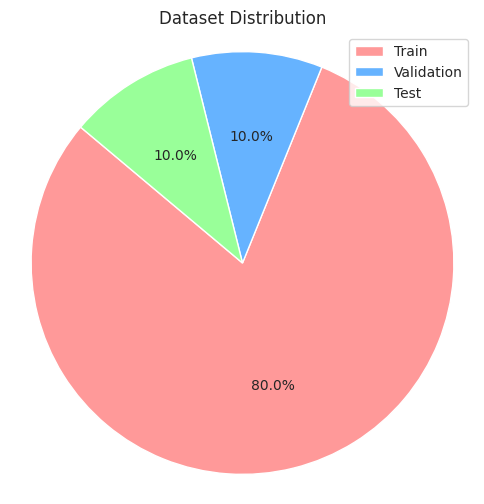

In [8]:
sizes = [
    sum(len(list((redistributed_data_path / 'train' / label).glob("*.jpeg"))) for label in LABELS),
    sum(len(list((redistributed_data_path / 'val' / label).glob("*.jpeg"))) for label in LABELS),
    sum(len(list((redistributed_data_path / 'test' / label).glob("*.jpeg"))) for label in LABELS)
]

print("Total number of images in the augmented dataset: ", sum(sizes))
titles = ['Train', 'Validation', 'Test']
plot_dataset_distribution(sizes, titles, 'Dataset Distribution')

       Class  Count
0     NORMAL   1242
1  PNEUMONIA   3442
Total:  4684


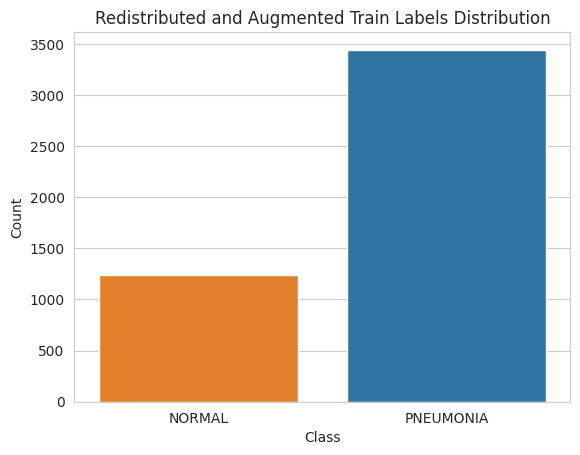

       Class  Count
0     NORMAL    177
1  PNEUMONIA    409
Total:  586


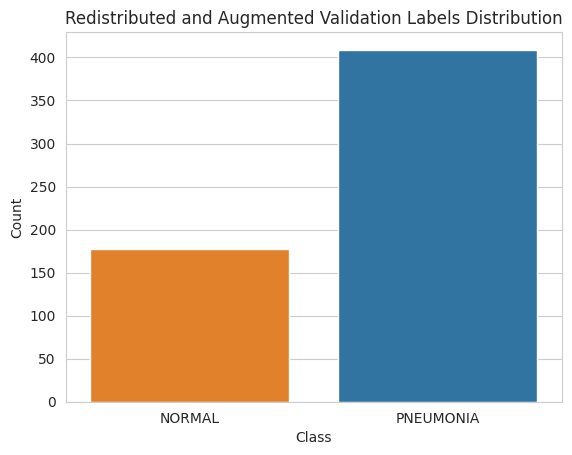

       Class  Count
0     NORMAL    164
1  PNEUMONIA    422
Total:  586


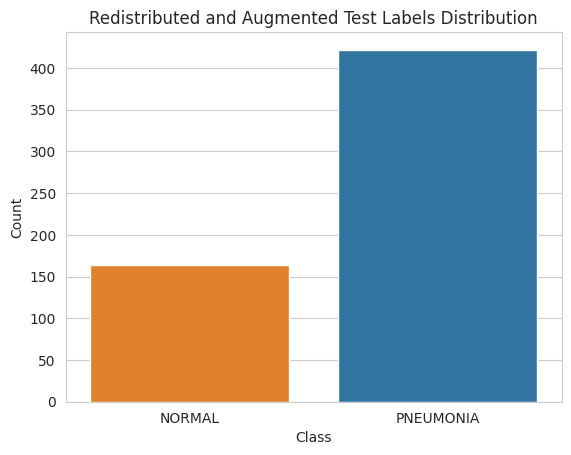

In [9]:
plot_labels_distribution(redistributed_data_path / 'train', LABELS, 'Redistributed and Augmented Train Labels Distribution')
plot_labels_distribution(redistributed_data_path / 'val' , LABELS, 'Redistributed and Augmented Validation Labels Distribution')
plot_labels_distribution(redistributed_data_path / 'test', LABELS, 'Redistributed and Augmented Test Labels Distribution')

The class imbalance is still not being solved, we will use data augmentation to mitigate this issue.

## Data Augmentation

In [10]:
def create_datagen():
    return tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )   

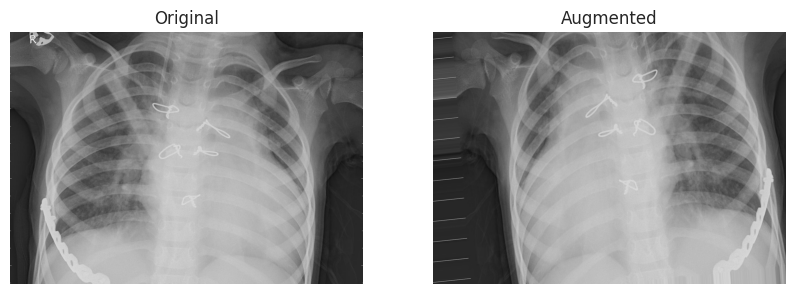

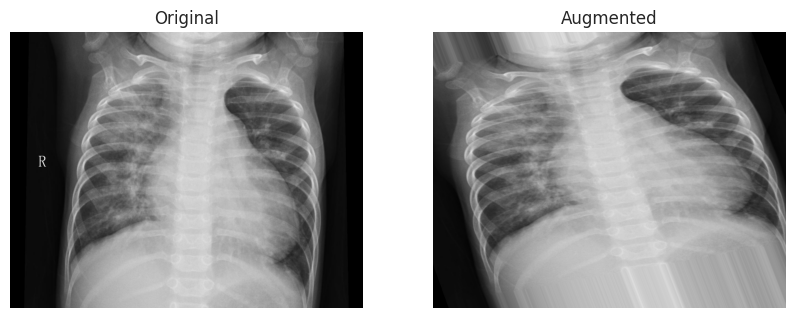

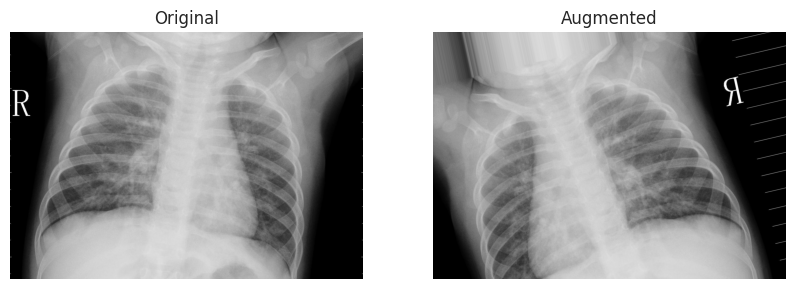

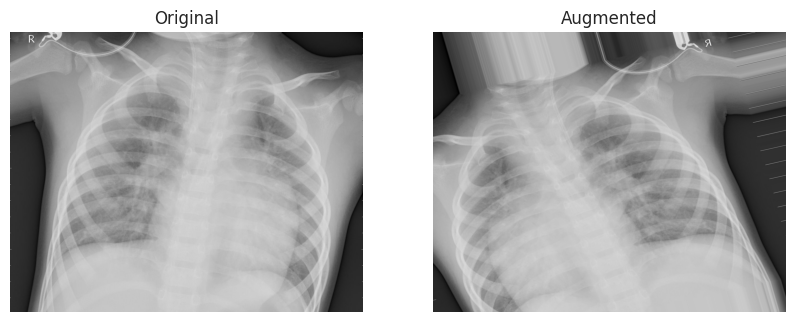

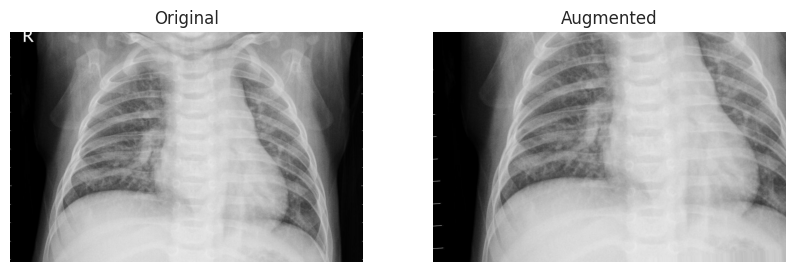

In [11]:
def show_augmentation_samples(data_dir, num_samples):
    datagen = create_datagen()

    image_files = list(Path(data_dir).glob('*.jpeg'))
    for image_path in random.sample(image_files, num_samples):
        img = Image.open(image_path)

        if GRAYSCALE:
            img = img.convert('L')  # grayscale
            img_array = np.array(img).reshape((1,) + img.size[::-1] + (1,))
        else:
            img = img.convert('RGB')  # RGB
            img_array = np.array(img).reshape((1,) + img.size[::-1] + (3,))

        plt.figure(figsize=(10, 5))

        # original image
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap='gray' if GRAYSCALE else None)
        plt.title("Original")
        plt.axis('off')

        # augmented image
        batch = next(datagen.flow(img_array, batch_size=1))
        augmented_img = batch[0].astype('uint8')
        plt.subplot(1, 2, 2)
        plt.imshow(augmented_img.squeeze(), cmap='gray' if GRAYSCALE else None)
        plt.title("Augmented")
        plt.axis('off')

        plt.show()

show_augmentation_samples(Path(data_path) / 'train' / 'PNEUMONIA', 5)

In [12]:
def augment_minority_class(redistributed_data_path, oversample_factor, drop_probability=0.3):
    train_normal_path = redistributed_data_path / 'train' / 'NORMAL'
    augmented_data_path = redistributed_data_path / 'train' / 'NORMAL_AUG'
    augmented_data_path.mkdir(parents=True, exist_ok=True)

    datagen = create_datagen()

    normal_images = list(train_normal_path.glob('*.jpeg'))
    for image_path in normal_images:
        img = Image.open(image_path)   
        img_array = np.array(img)
        
        if len(img_array.shape) == 2:  # grayscale image
            img_array = img_array.reshape((1,) + img_array.shape + (1,))
        elif len(img_array.shape) == 3 and img_array.shape[-1] == 3:  # RGB
            img_array = img_array.reshape((1,) + img_array.shape)
        else:
            raise ValueError(f"Unexpected image shape: {img_array.shape}")
        
        for _ in range(oversample_factor):
            if random.random() < drop_probability:
                continue
            for batch in datagen.flow(img_array, batch_size=1, save_to_dir=augmented_data_path, save_prefix='aug', save_format='jpeg'):
                break

    # combine augmented data with original data
    for aug_image in augmented_data_path.glob('*.jpeg'):
        shutil.copy(aug_image, train_normal_path)

    # remove augmented data directory
    shutil.rmtree(augmented_data_path)

augment_minority_class(redistributed_data_path, oversample_factor=2)

       Class  Count
0     NORMAL   2851
1  PNEUMONIA   3442
Total:  6293


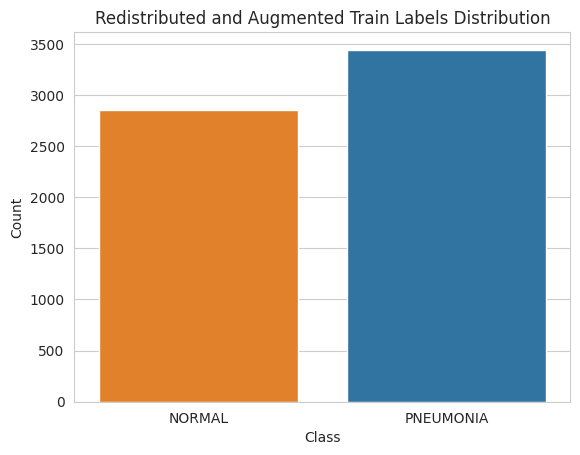

In [13]:
plot_labels_distribution(redistributed_data_path / 'train', LABELS, 'Redistributed and Augmented Train Labels Distribution')